# 2. Data preparation

---

### Setup

In [1]:
import sys
sys.path.insert(1, '../../utils')

import pandas as pd

original: pd.DataFrame = pd.read_csv('../qsar_oral_toxicity_after_profiling.csv', sep=';')

## 2.0. Data preparation

---

### Missing Values Imputation

---

In our dataset there are no missing values and therefore this step is not appliable.

### Outliers Imputation
---

In [2]:
#TODO

### Scaling

---

Since all variables are binary (0 or 1) they are already scaled. Therefore, no scaling is needed.

### Splits

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ds_functions as ds

original_copy = original.copy(deep = True)

target = 'exp'
positive = True
negative = False
values = {'Original': [len(original_copy[original_copy[target] == positive]), len(original_copy[original_copy[target] == negative])]}

y: np.ndarray = original_copy.pop(target).values
X: np.ndarray = original_copy.values
labels: np.ndarray = pd.unique(y)

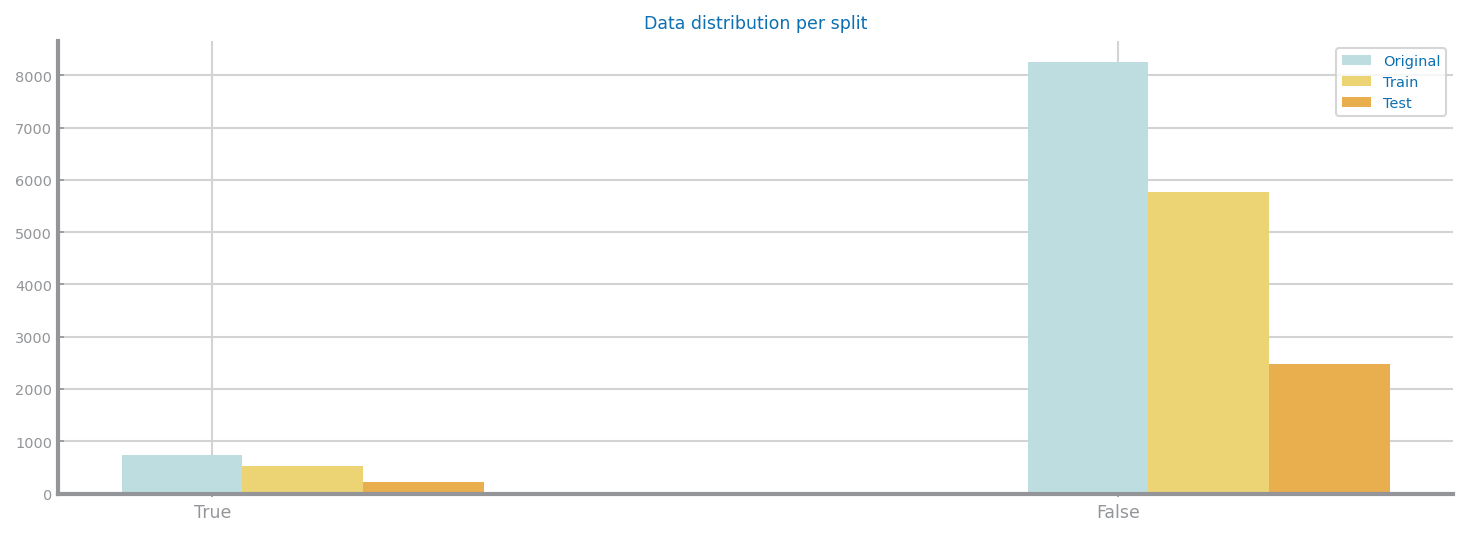

In [4]:
trnX, tstX, trnY, tstY = train_test_split(X, y, train_size=0.7, stratify=y)
values['Train'] = [len(np.delete(trnY, np.argwhere(trnY==negative))), len(np.delete(trnY, np.argwhere(trnY==positive)))]
values['Test'] = [len(np.delete(tstY, np.argwhere(tstY==negative))), len(np.delete(tstY, np.argwhere(tstY==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per split', showXTickLabels = True)
plt.show()

### Data balancing

---

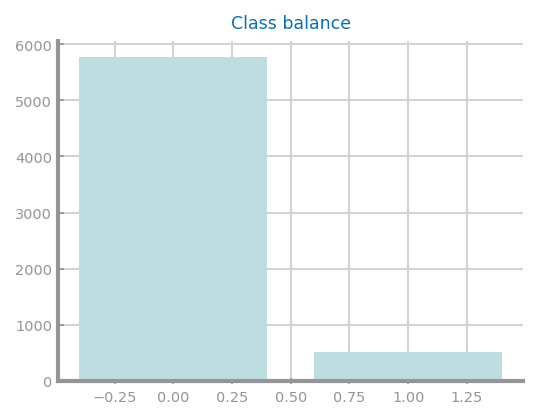

Minority class: 519
Majority class: 5774
Proportion: 0.09 : 1


In [5]:
import matplotlib.pyplot as plt

split = {}

columnsX = list(original.columns)
columnsX.remove(target)

split['X_train'] = pd.DataFrame(data=trnX, columns=columnsX)
split['y_train'] = pd.DataFrame(data=trnY, columns=[target])
split['X_test'] = pd.DataFrame(data=tstX, columns=columnsX)
split['y_test'] = pd.DataFrame(data=tstY, columns=[target])

trainData = pd.concat([split['X_train'], split['y_train']], axis = 1)
testData = pd.concat([split['X_test'], split['y_test']], axis = 1)

target_count = trainData['exp'].value_counts()
plt.figure()
plt.title('Class balance')
plt.bar(target_count.index, target_count.values)
plt.show()

min_class = target_count.idxmin()
ind_min_class = target_count.index.get_loc(min_class)

print('Minority class:', target_count[ind_min_class])
print('Majority class:', target_count[1-ind_min_class])
print('Proportion:', round(target_count[ind_min_class] / target_count[1-ind_min_class], 3), ': 1')

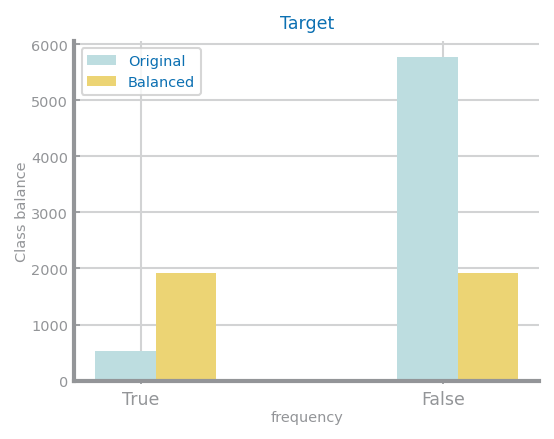

In [6]:
import ds_functions as ds

df_class_min = trainData[trainData['exp'] == min_class]
df_class_max = trainData[trainData['exp'] != min_class]

values = {'Original': [target_count.values[ind_min_class], target_count.values[1-ind_min_class]]}

FINAL_SIZE = len(df_class_max) // 3

# Oversampling
df_class_min_sample = df_class_min.sample(FINAL_SIZE, replace=True)
# Undersampling
df_class_max_sample = df_class_max.sample(FINAL_SIZE)

values['Balanced'] = [len(df_class_min_sample), len(df_class_max_sample)]

fig = plt.figure()
ds.multiple_bar_chart([target_count.index[ind_min_class], target_count.index[1-ind_min_class]], values,
                      title='Target', xlabel='frequency', ylabel='Class balance', showXTickLabels=True)
plt.show()

balanced = pd.concat((df_class_min_sample, df_class_max_sample))

In [7]:
# Finally, export prepared data to csv
trainData.to_csv('data/prepared/data.csv', sep=';', index=False)
balanced.to_csv('data/prepared_b/data.csv', sep=';', index=False)
testData.to_csv('data/prepared_test/data.csv', sep=';', index=False)

### Feature Selection

---

#### Unsupervised Selection

By definition, unsupervised selection only aims for eliminating redundancies among the
variables, getting the smallest set possible.

In [8]:
import seaborn as sns
import numpy as np

data_dict = {'balanced': balanced, 'train': trainData}
data_dict_unsupervised = {'balanced': None, 'train': None}

for key in data_dict:
    df = data_dict[key]
    
    copy = df.copy(deep=True)
    copy = copy.drop('exp', axis = 1)
    corrs = copy.corr()

    removed = []

    for x in corrs:
        for y in corrs:
            if x == y:
                break
            corr = corrs[x][y]
            if abs(corr) >= 0.8 and x not in removed and y not in removed:
                copy = copy.drop(x, axis=1)
                removed.append(x)
                break

    copy['exp'] = df['exp']
    
    data_dict_unsupervised[key] = copy.copy(deep=True)

#### Supervised Selection

In the context of supervised selection, the goal is to identify the most relevant variables
in relation to the target variable, and so we need criteria able to relate each variable
with the target one.

In [9]:
importances = {'balanced': None, 'train': None}

for key in data_dict_unsupervised:
    importances[key] = data_dict_unsupervised[key].drop('exp', axis=1).apply(lambda x: x.corr(copy.exp))
    print('%s\n\n' % key, importances[key], '\n\n\n')

balanced

 bmf1      -0.062907
bmf2       0.038814
bmf3       0.139339
bmf4       0.134021
bmf5      -0.020016
             ...   
bmf1020    0.037679
bmf1021   -0.008374
bmf1022   -0.026223
bmf1023    0.004973
bmf1024   -0.052266
Length: 959, dtype: float64 



train

 bmf1      -0.044629
bmf2       0.029381
bmf3       0.068602
bmf4       0.070642
bmf5      -0.016739
             ...   
bmf1020    0.019029
bmf1021   -0.008409
bmf1022    0.006734
bmf1023    0.006734
bmf1024   -0.019340
Length: 959, dtype: float64 





In [10]:
new_data_dict_unsupervised = {'balanced': None, 'train': None}
for key in data_dict_unsupervised:
    new_data_dict_unsupervised[key] = data_dict_unsupervised[key].copy(deep=True)

    for i in range(0, len(importances[key])):
        if np.abs(importances[key][i]) < 0.10:
            new_data_dict_unsupervised[key] = new_data_dict_unsupervised[key].drop(importances[key].index[i], axis=1)

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pandas as pd

newest_copy = {'balanced': None, 'train': None}
for key in new_data_dict_unsupervised:
    newest_copy[key] = new_data_dict_unsupervised[key].copy(deep=True)

    X = pd.get_dummies(newest_copy[key].drop('exp', axis=1))
    y = pd.get_dummies(newest_copy[key]['exp'])


    #feature selection using chi2
    bestfeatures = SelectKBest(score_func=chi2, k='all')
    fit = bestfeatures.fit(X, y)
    #create df for scores
    dfscores = pd.DataFrame(fit.scores_)
    #create df for column names
    dfcolumns = pd.DataFrame(X.columns)

    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    #naming the dataframe columns
    featureScores.columns = ['Selected_columns','Score_chi2']

    for i in range(0, len(featureScores)):
        if featureScores['Score_chi2'][i] <= 50:
            newest_copy[key] = newest_copy[key].drop(featureScores['Selected_columns'][i], axis=1)

In [12]:
newest_copy['balanced'].to_csv('data/prepared_b_s/data.csv', sep=';', index=False)
newest_copy['train'].to_csv('data/prepared_s/data.csv', sep=';', index=False)

### Summary

---

***Are all variables in the same scale? If not, how does scaling impact the results?***

Yes, they are all binary and, therefore, all in the same scale.

***Is the dataset unbalanced? If yes, what is the best balancing technique to apply?***

Yes, the dataset is way unbalanced. To balance it we used two techniques: oversampling for the minority class (positive) and undersampling for the majority class (negative).